In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from composition_stats import ilr, ilr_inv, closure
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
raw_data = pd.read_excel("Datos_Market_copy.xlsx")

data = raw_data.copy()
data.set_index("date", inplace=True)

In [10]:
ilr_data = ilr(data[["value.sales", "unit.sales", "volume.sales"]].values)

ilr_columns = [f"ilr_{i+1}" for i in range(ilr_data.shape[1])]  # Set column names
ilr_sales_df = pd.DataFrame(ilr_data, columns=ilr_columns, index=raw_data["date"])

data_withILR = pd.concat([data, ilr_sales_df], axis=1)
data_withILR = data_withILR.drop(
    columns=["value.sales", "unit.sales", "volume.sales", "acv.distribution"]
)

# We're gonna group some data for simplicity
for i in data_withILR["brand"]:
    if i != "brand-15" and i != "brand-14" and i != "brand-35":
        # change the name
        # test_data["brand"].replace(i, "other", inplace=True)
        data_withILR["brand"].replace({i: "other"}, inplace=True)


print("We will use only four brands in our data", data_withILR["brand"].unique())

/var/folders/r4/_d0jbzx9629841ty8b0gfn040000gn/T/ipykernel_8452/3515631567.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_withILR["brand"].replace({i: "other"}, inplace=True)


We will use only four brands in our data ['brand-35' 'brand-14' 'other' 'brand-15']


Filter **DATA**

In [11]:
# variant = data_withILR["variant"] == "standard"

pack_size = data_withILR["pack.size"] == "0 - 350 GR"
brand = data_withILR["brand"].isin(["brand-35"])  # , "brand-15", "brand-14"
variant = data_withILR["variant"].isin(["flavoured"])
supermarket = data_withILR["supermarket"].isin(
    ["supermarket-A"]
)  # , "supermarket-B", "supermarket-C", "supermarket-D"

data_filtered = data_withILR[(variant) & (pack_size)]  # & (brand) & (supermarket)
data_filtered_withoutILR = data[(variant) & (pack_size) & (brand) & (supermarket)]
data_filtered.head()

,variant,pack.size,brand,supermarket,ilr_1,ilr_2
date,,,,,,
2021-01-09,flavoured,0 - 350 GR,brand-35,supermarket-A,-0.133943,1.046681
2021-01-09,flavoured,0 - 350 GR,brand-35,supermarket-D,-0.016536,1.165033
2021-01-09,flavoured,0 - 350 GR,brand-35,supermarket-C,-0.380379,0.866473
2021-01-09,flavoured,0 - 350 GR,brand-14,supermarket-A,0.025182,1.587820
2021-01-09,flavoured,0 - 350 GR,brand-14,supermarket-B,0.419516,1.478488


ANALYSIS

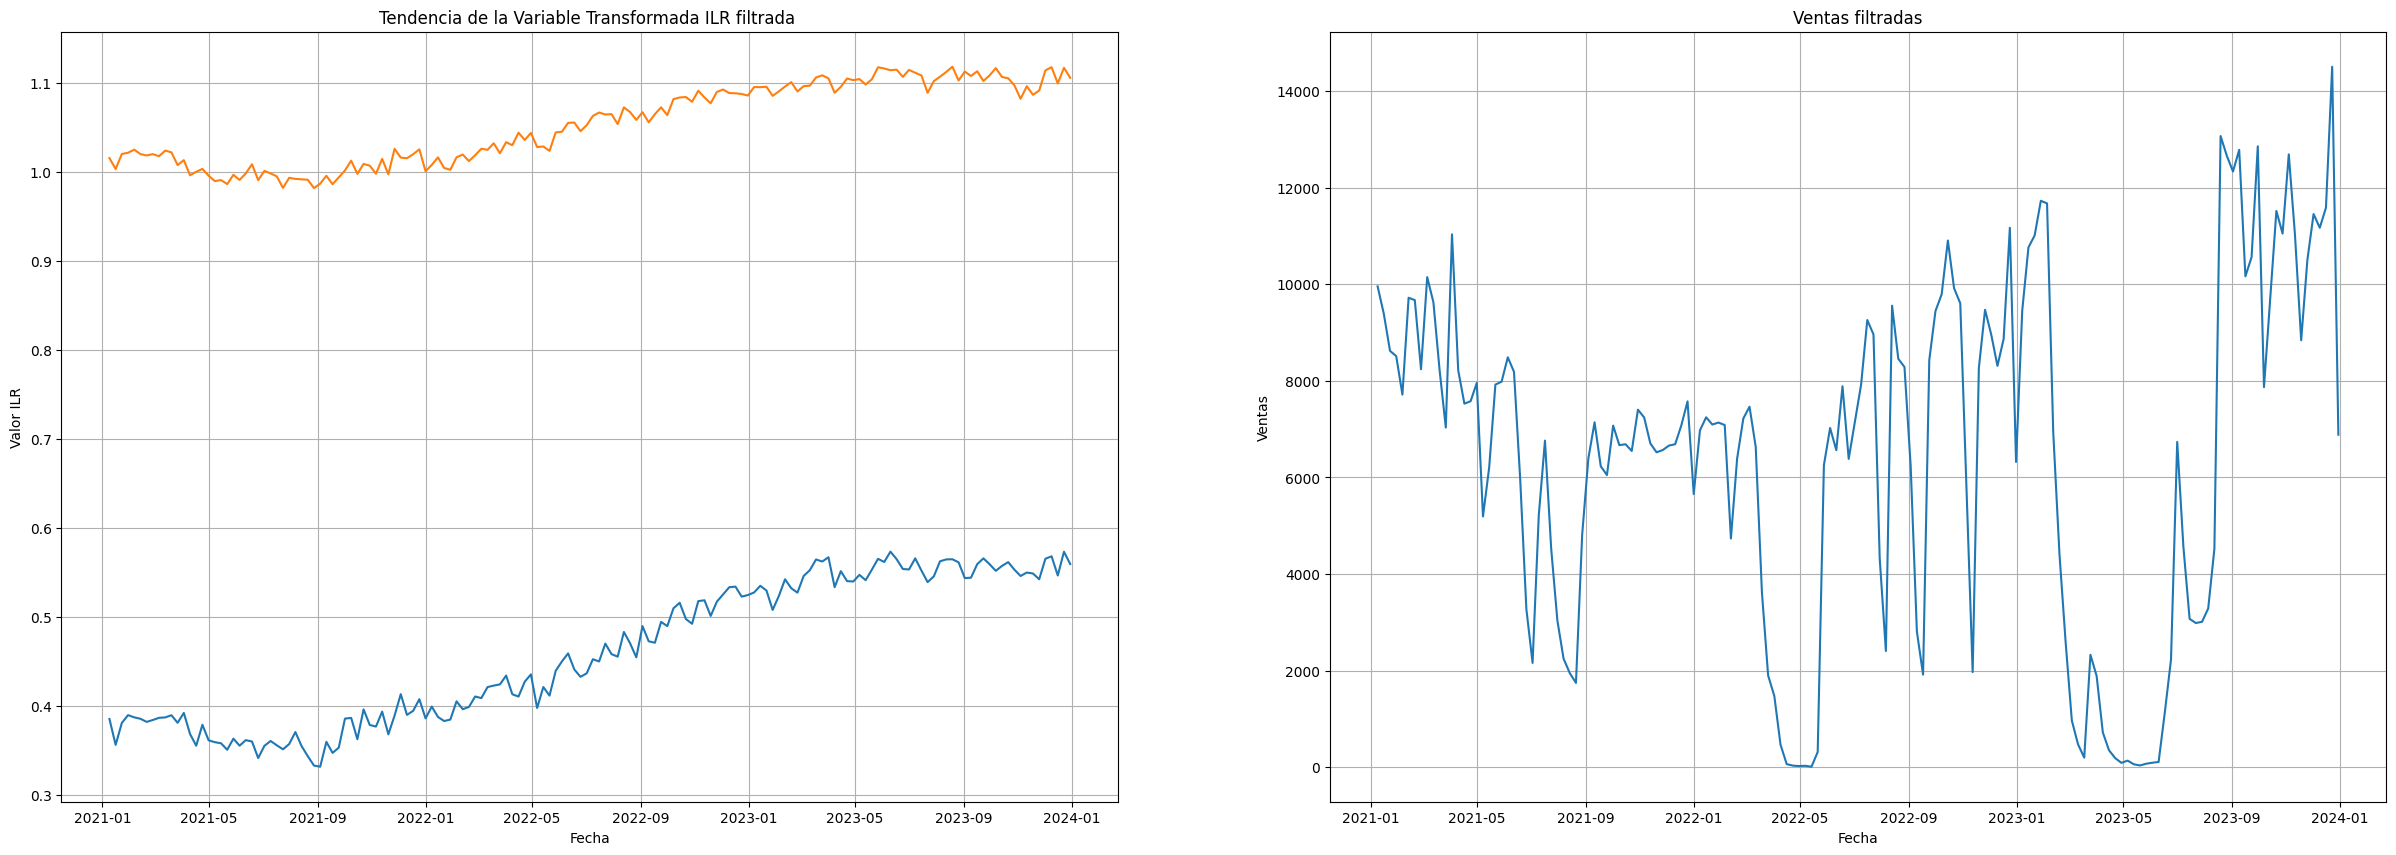

In [14]:
ilr_trends = data_withILR.groupby("date")[["ilr_1", "ilr_2"]].mean()

# Crear la visualización de las tendencias
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ax[0].plot(ilr_trends.index, ilr_trends["ilr_1"], label="ILR 1")
ax[0].plot(ilr_trends.index, ilr_trends["ilr_2"], label="ILR 2")
ax[0].set_title("Tendencia de la Variable Transformada ILR filtrada ")
ax[0].set_xlabel("Fecha")
ax[0].set_ylabel("Valor ILR")
ax[0].grid(True)

ax[1].plot(
    data_filtered_withoutILR.index,
    data_filtered_withoutILR["value.sales"],
    label="value.sales",
)
ax[1].set_title("Ventas filtradas")
ax[1].set_xlabel("Fecha")
ax[1].set_ylabel("Ventas")
ax[1].grid(True)

plt.show()

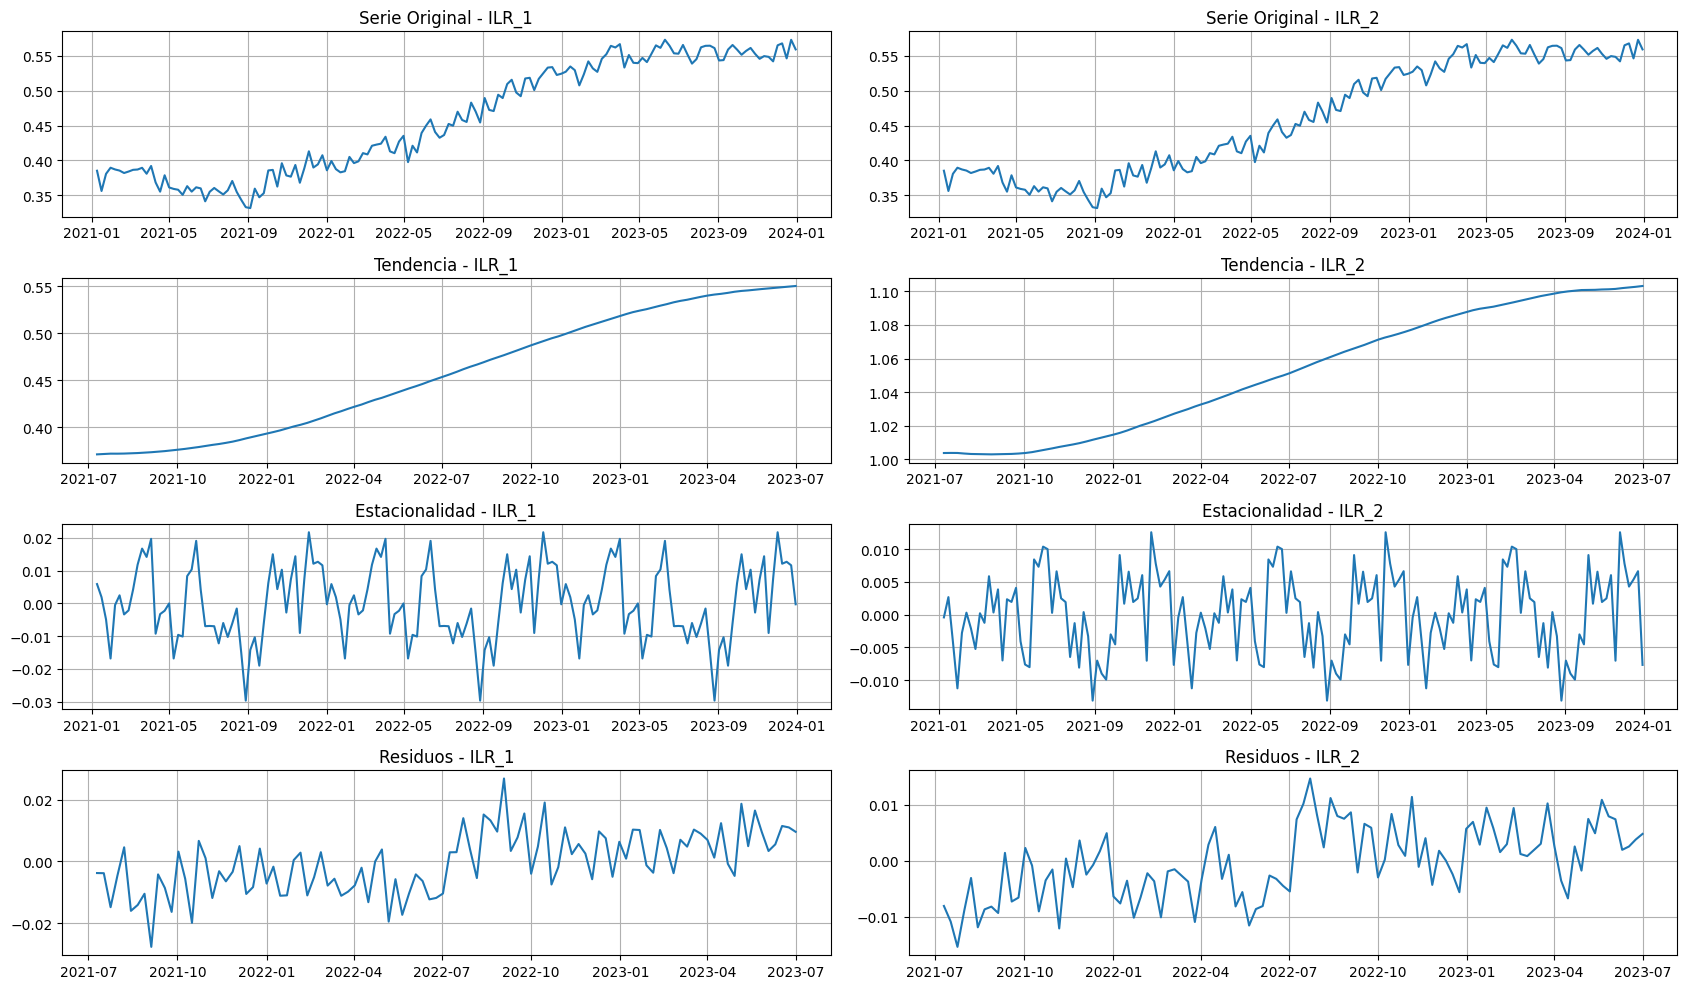

In [15]:
# %matplotlib widget
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizar la descomposición aditiva con los data_ilr interpolados
decomposition_add_ilr_1 = seasonal_decompose(
    ilr_trends["ilr_1"], model="additive", period=52
)
decomposition_add_ilr_2 = seasonal_decompose(
    ilr_trends["ilr_2"], model="additive", period=52
)

fig, ax = plt.subplots(4, 2, figsize=(17, 10))

ax[0, 0].plot(decomposition_add_ilr_1.observed)
ax[0, 0].set_title("Serie Original - ILR_1")
ax[0, 0].grid(True)

ax[1, 0].plot(decomposition_add_ilr_1.trend)
ax[1, 0].set_title("Tendencia - ILR_1")
ax[1, 0].grid(True)

ax[2, 0].plot(decomposition_add_ilr_1.seasonal)
ax[2, 0].set_title("Estacionalidad - ILR_1")
ax[2, 0].grid(True)

ax[3, 0].plot(decomposition_add_ilr_1.resid)
ax[3, 0].set_title("Residuos - ILR_1")
ax[3, 0].grid(True)

ax[0, 1].plot(decomposition_add_ilr_1.observed)
ax[0, 1].set_title("Serie Original - ILR_2")
ax[0, 1].grid(True)

ax[1, 1].plot(decomposition_add_ilr_2.trend)
ax[1, 1].set_title("Tendencia - ILR_2")
ax[1, 1].grid(True)

ax[2, 1].plot(decomposition_add_ilr_2.seasonal)
ax[2, 1].set_title("Estacionalidad - ILR_2")
ax[2, 1].grid(True)

ax[3, 1].plot(decomposition_add_ilr_2.resid)
ax[3, 1].set_title("Residuos - ILR_2")
ax[3, 1].grid(True)

plt.tight_layout()
plt.show()

# # box plot of the ilr transformed data
# plt.figure(figsize=(12, 6))
# data_filtered[ilr_columns].boxplot()
# plt.ylabel("ILR transformed data")
# plt.title("Box plot of the ILR transformed data")
# plt.grid(True)
# plt.show()

ARIMAX